In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import nltk
import gensim
from tqdm import tqdm_notebook
#from tqdm import tqdm
from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, ReversibleField
from torchtext.datasets import WikiText2
from torchtext import data

SEED = 42
np.random.seed(SEED)

In [0]:
device = tt.device('cuda') if tt.cuda.is_available() else tt.device('cpu')

In [0]:
import spacy


spacy_en = spacy.load('en')
spacy_en.remove_pipe('tagger')
spacy_en.remove_pipe('ner')

from spacy.symbols import ORTH

In [0]:
spacy_en.tokenizer.add_special_case("don't", [{ORTH: "do"}, {ORTH: "n't"}])

In [0]:
def tokenizer(text): 
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [47]:
!pip install revtok

In [0]:
TEXT = ReversibleField(use_vocab=True,  
                      tokenize=tokenizer,
                      batch_first=True,
                      init_token='<start>', eos_token='<end>',
                      lower=True)                       

In [0]:
train, valid, test = WikiText2.splits(TEXT)

In [0]:
TEXT.build_vocab(train, valid, test, min_freq=10, vectors="glove.6B.200d")

In [97]:
len(TEXT.vocab.itos)

14366

In [0]:
train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=32,
    bptt_len=30,
    device=device,
    repeat=False)

In [99]:
b = next(iter(train_iter))
vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

In [60]:
b.text[:5, :3]

tensor([[   14,  1878,     0],
        [   15,    12,    32],
        [   14,    34,     4],
        [   17,   509, 11471],
        [ 4479,    24,  3190]])

In [61]:
b.target[:5, :3]

tensor([[   15,    12,    32],
        [   14,    34,     4],
        [   17,   509, 11471],
        [ 4479,    24,  3190],
        [ 4178,   297,     7]])

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=0.1):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.drop = nn.Dropout(dropout)
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           dropout=dropout,
                           batch_first=True,
                           bidirectional=True
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    
    def forward(self, batch):               
        x = batch.text.T       
        x = self.embedding(x)           
        x, _= self.rnn(x)       
        x = self.fc(x)

        return x.transpose(1,2)

In [101]:
model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=1)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
def train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()
    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()
        
        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss

def test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with tt.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches


def nn_train(model, train_iter, valid_iter, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()


    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_iter, optimizer, criterion, epoch)
        valid_loss = test_epoch(model, valid_iter, criterion)

        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    
    return history

In [104]:
history = nn_train(model, train_iter, valid_iter, criterion, optimizer, scheduler=scheduler, 
        n_epochs=10, early_stopping=2)

validation loss 2.25416


validation loss 1.03330


validation loss 0.56832


validation loss 0.39875


validation loss 0.32670


validation loss 0.29585


validation loss 0.28147


validation loss 0.27542


validation loss 0.27583


validation loss 0.27584
Early stopping! best epoch: 7 val 0.27542


In [106]:
history

,epoch,train_loss,valid_loss
0,0.0,3.792782,2.254157
1,1.0,1.535402,1.033301
2,2.0,0.656551,0.568321
3,3.0,0.351840,0.398753
4,4.0,0.240745,0.326701
5,5.0,0.192715,0.295853
6,6.0,0.167047,0.281474
7,7.0,0.150208,0.275423
8,8.0,0.136525,0.275830
9,9.0,0.124910,0.275840


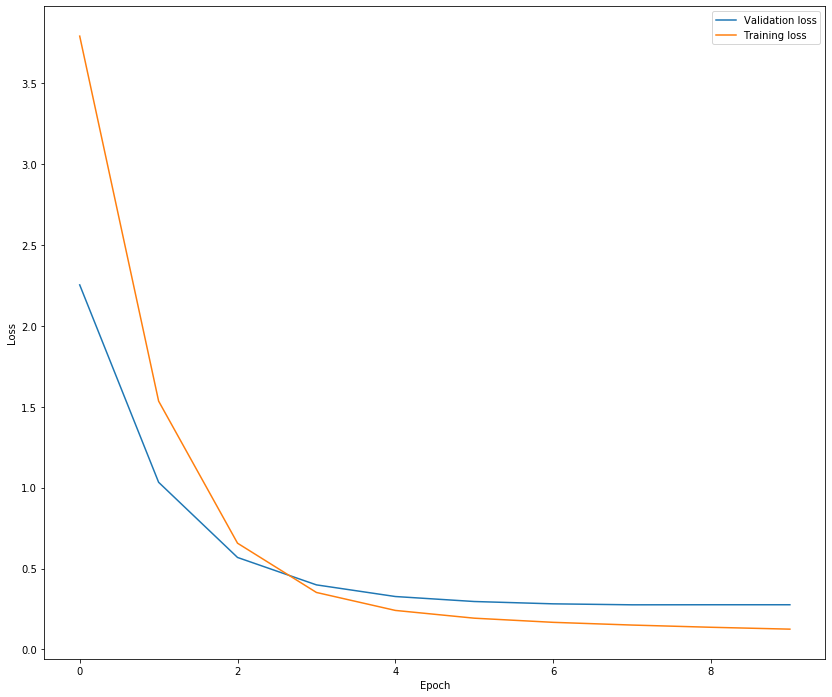

In [119]:
plt.figure(figsize=(14, 12))
plt.plot(list(range(len(history.valid_loss))),history.valid_loss, label='Validation loss')
plt.plot(list(range(len(history.train_loss))),history.train_loss, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')